In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings

from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox

warnings.filterwarnings('ignore')
%matplotlib inline
# plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [20,8]
# lags=60
# precent_train_set = 0.9
# rolling_value = 10


# GDP Ukraine

In [3]:
df = pd.read_csv('../../data_dm/eugen/gdp_poland.csv', header=0, index_col=0, parse_dates=True)
df = df / 1e+10
y = df
df

,gdp
Data,
1990-01-01,6.597775
1991-01-01,8.550094
1992-01-01,9.433705
1993-01-01,9.604565
1994-01-01,11.080339
1995-01-01,14.229278
1996-01-01,16.019324
1997-01-01,15.935779
1998-01-01,17.468579


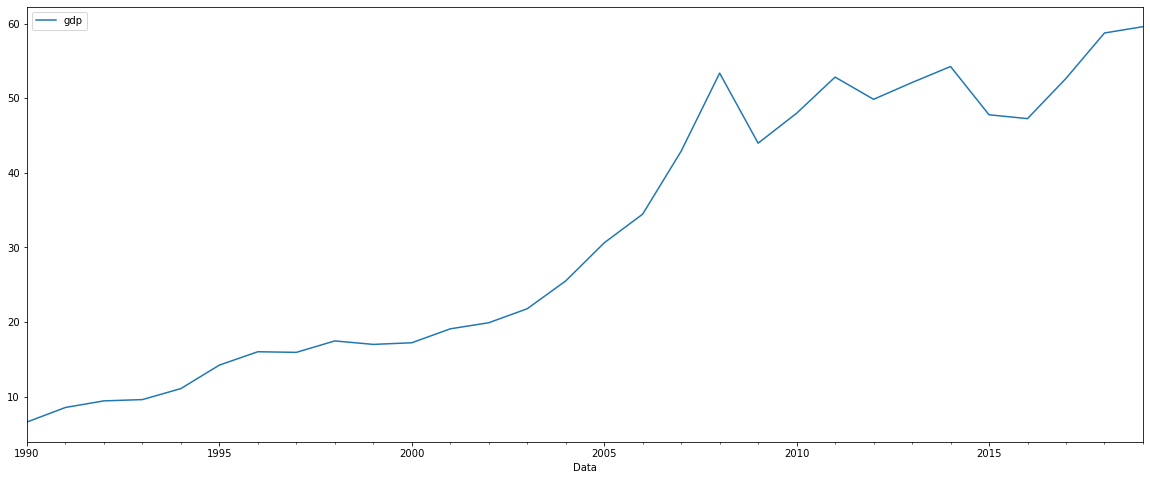

In [4]:
df.plot()

## Augmented Dickey-Fuller Test

In [9]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [10]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.399
P-value = 0.910
Critical values :
	1%: -3.6790595944893187 - The data is not stationary with 99% confidence
	5%: -2.9678817237279103 - The data is not stationary with 95% confidence
	10%: -2.6231583472057074 - The data is not stationary with 90% confidence


## Detrending

In [17]:
rolling_value = 2


 > Is the de-trended data stationary ?
Test statistic = -5.418
P-value = 0.000
Critical values :
	1%: -3.6889256286443146 - The data is  stationary with 99% confidence
	5%: -2.9719894897959187 - The data is  stationary with 95% confidence
	10%: -2.6252957653061224 - The data is  stationary with 90% confidence


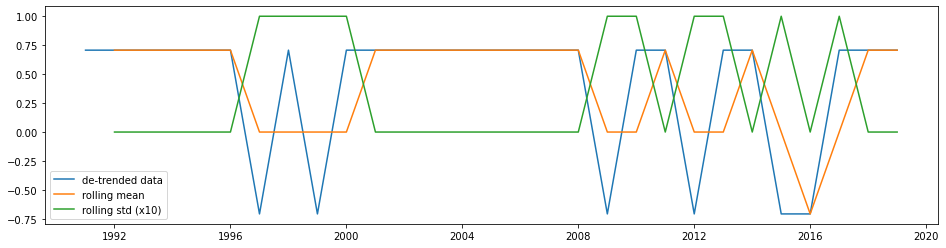

In [18]:
# Detrending
y_detrend =  (y - y.rolling(window=rolling_value).mean())/y.rolling(window=rolling_value).std()

test_stationarity(y_detrend.gdp,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Differencing

 > Is the 1 lag differenced data stationary ?
Test statistic = -5.364
P-value = 0.000
Critical values :
	1%: -3.6889256286443146 - The data is  stationary with 99% confidence
	5%: -2.9719894897959187 - The data is  stationary with 95% confidence
	10%: -2.6252957653061224 - The data is  stationary with 90% confidence


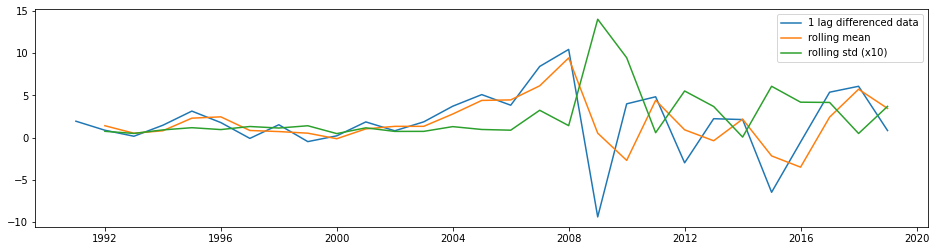

In [19]:
# Differencing
diff_model = 1
y_10lag =  y - y.shift(diff_model)

test_stationarity(y_10lag.gdp,f'{diff_model} lag differenced data')
ADF_test(y_10lag,f'{diff_model} lag differenced data')

## Combining Detrending and Differencing


 > Is the 1 lag differenced de-trended data stationary ?
Test statistic = -6.887
P-value = 0.000
Critical values :
	1%: -3.7112123008648155 - The data is  stationary with 99% confidence
	5%: -2.981246804733728 - The data is  stationary with 95% confidence
	10%: -2.6300945562130176 - The data is  stationary with 90% confidence


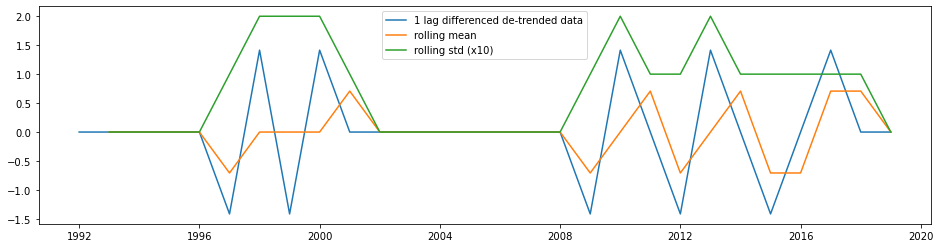

In [20]:
y_10lag_detrend =  y_detrend - y_detrend.shift(diff_model)

test_stationarity(y_10lag_detrend.gdp,f'{diff_model} lag differenced de-trended data')
ADF_test(y_10lag_detrend.gdp,f'{diff_model} lag differenced de-trended data')

## Create Training & Testing Datasets


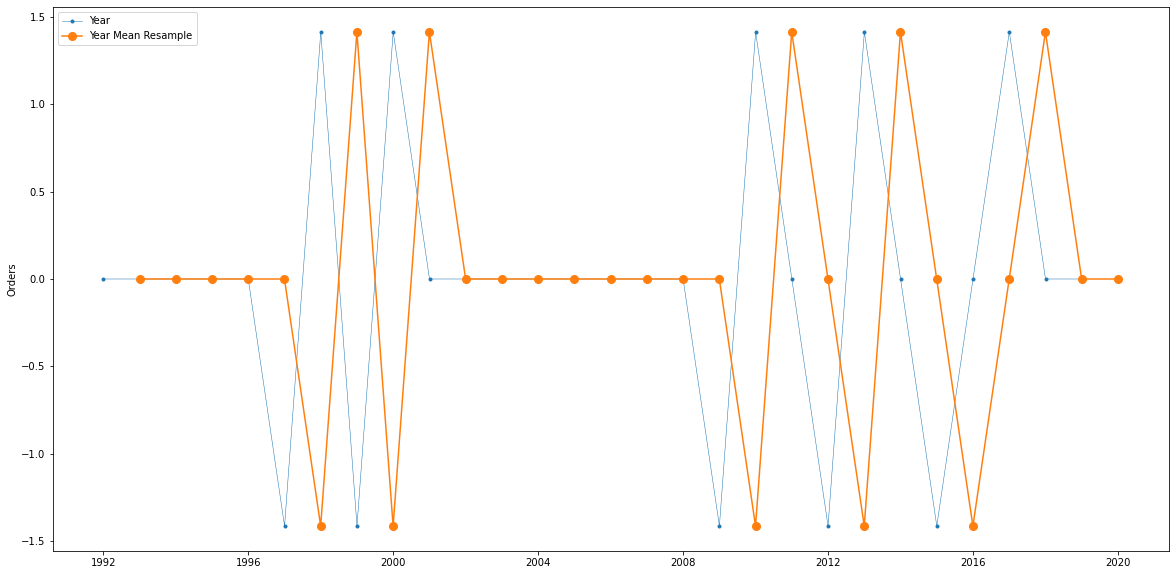

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_10lag_detrend,marker='.', linestyle='-', linewidth=0.5, label='Year')
ax.plot(y_10lag_detrend.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

In [22]:
def calculate_metrics_sample(y):
   
    print('yes')
    sample = pd.Series(y)
    
    y_dict = dict()

#     y_dict['series'] = 'Y'
    
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return pd.DataFrame(np.array([[metr] for metr in y_dict.values()]).T, 
                        columns=[ 'observations', 'mode','mean','median',
                                 'variation','skewness','kurtosis','jarque-bera','probability']).astype('float16')#,'params_ar','params_intercept'])

## Metrics

In [23]:
# columns =['name', 'r2', 'RMSE','MAE','sum_squared_resid','AIC','durbin_watson','theil_index']

# models_metrics_static = pd.DataFrame(columns=columns)
# models_metrics_static_test = pd.DataFrame(columns=columns)

calculate_metrics_sample(y.gdp)

yes


,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,30.00000000,6.59765625,31.92187500,28.06250000,331.25000000,0.11840820,-1.69042969,3.32421875,0.18969727


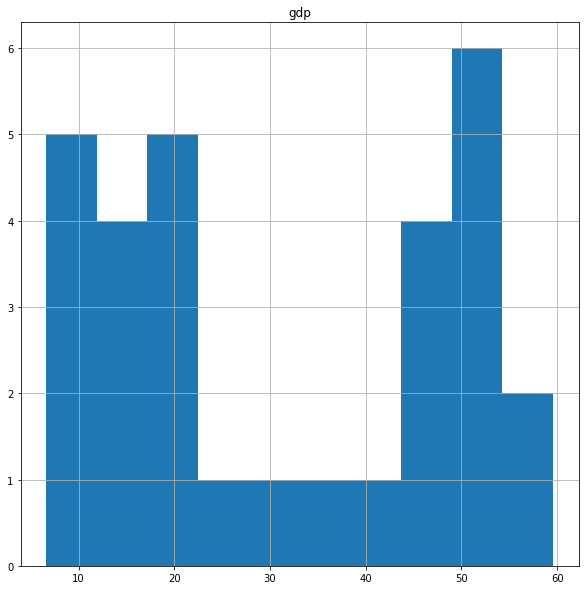

In [24]:
y.hist(figsize=(10,10))
plt.show()

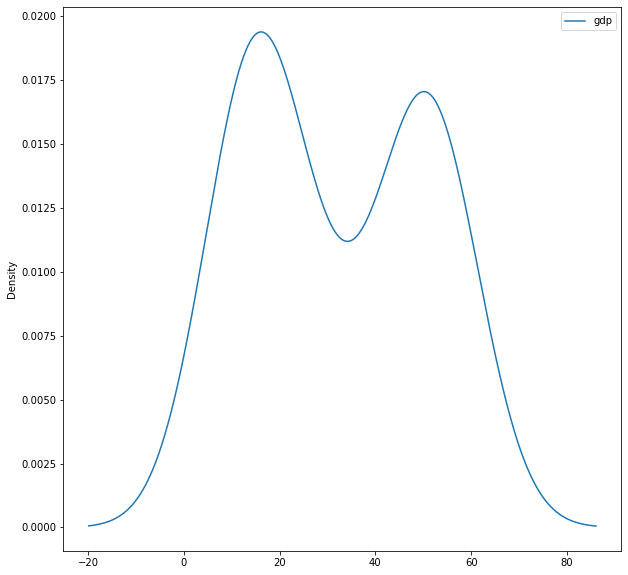

In [25]:
y.plot(kind='kde', figsize=(10,10))
plt.show()

In [28]:
def show_plots(y):
    sample = pd.Series(y)
#     plt.subplot(311)
#     plt.figure(figsize=(20,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample, marker='o')
    plt.grid(True)
    

#     plt.subplot(312)
    plot_acf(sample, lags=lags);
    
#     plt.subplot(313)
    plot_pacf(sample, lags=lags);
    
    plt.show()

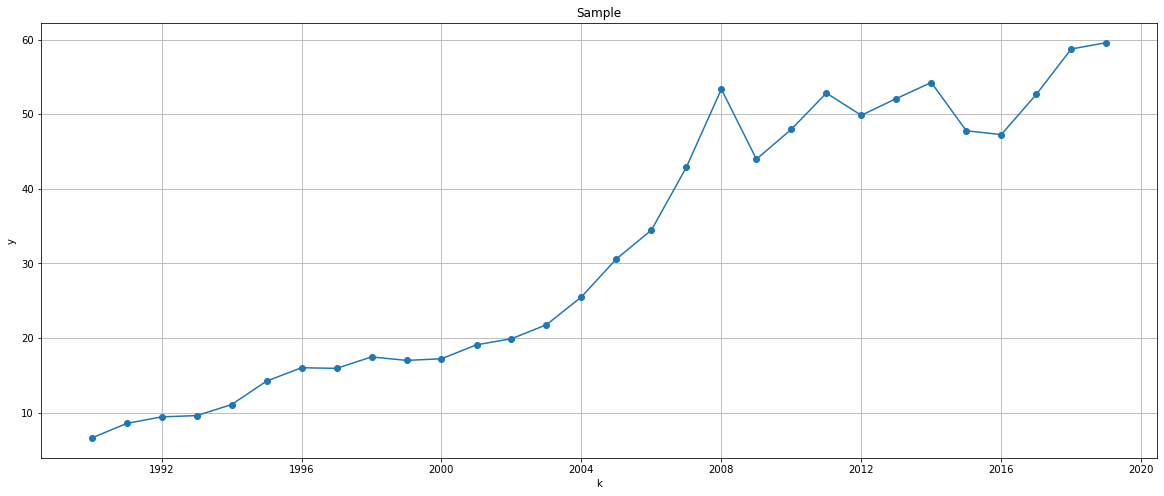

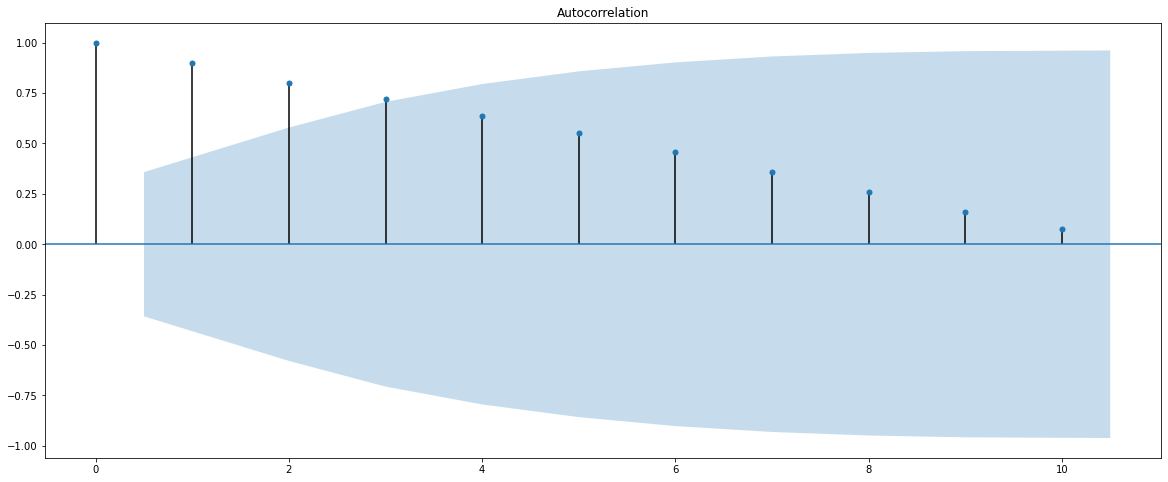

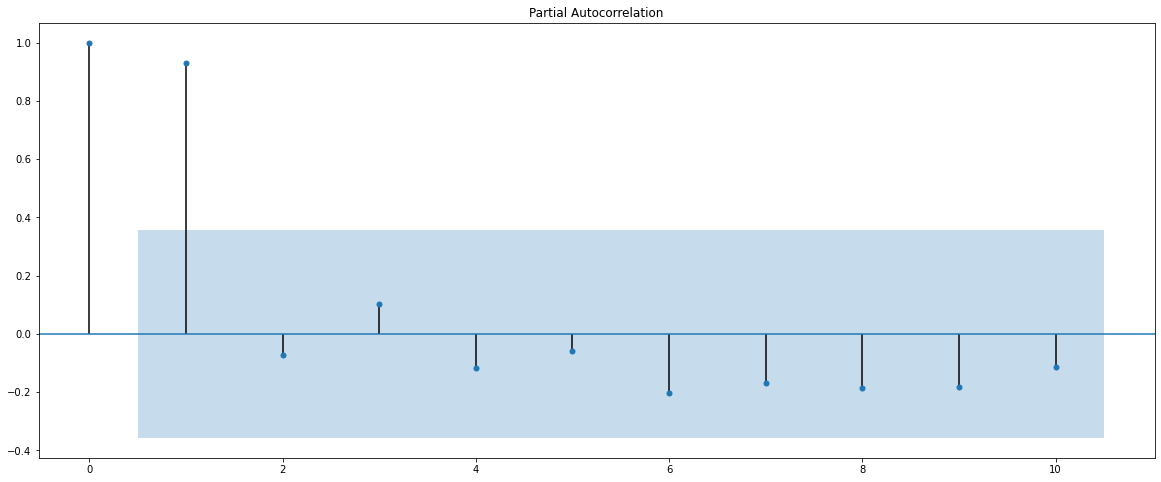

In [29]:
lags=10
show_plots(y.gdp)

## Preparing data 


In [29]:
## Preparing data 
p = 2
q = 7


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

def barplot(data, title):
#     fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=data['feature'], y=data['value'])
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

class DiffData(BaseEstimator, TransformerMixin):
    
    def __init__(self, diff_model=0, box_cox=False, ln=False):
        self.diff_model = diff_model
        self.box_cox = box_cox
        self.ln = ln
        
    def fit(self, X, y=None):
        
        index = X.index
        y_value = X['gdp'].values
                
#         print(X_copy)
        if self.box_cox:
            transformed, self.lmbd = boxcox(y_value)   

            
        if not self.box_cox and self.ln:
            transformed = np.log(y_value)
            
        transformed = pd.DataFrame({f'value' : y_value}, index=index)             
        
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        
        index = X.index
        y_value = X['gdp'].values
        
        if self.box_cox:
            transformed  = boxcox(y_value, lmbda=self.lmbd)
        
        if not self.box_cox and self.ln:
            transformed = np.log(y_value)
        
        transformed = pd.DataFrame({f'value' : y_value}, index=index)
        
#         transformed =  (transformed - transformed.shift(self.diff_model)).dropna()
        if self.diff_model:
            transformed =  transformed - transformed.shift(self.diff_model)
        
        
        return transformed
    
class PrepareData(BaseEstimator, TransformerMixin):
    def __init__(self, lags=0, window=2):
#         self.box_cox = box_cox
        self.lags = lags
        self.window = window
#         self.diff = diff_model
        
    def fit(self, X, y=None):
#         X_copy = X.copy()
        
#         transformed = pd.DataFrame()
        
#         if self.box_Cox:
#             transformed, self.lmbd = boxcox(X_copy)            
        
#         transformed =  transformed - transformed.shift(self.diff_model)

        
#         for i in range(1, self.lags + 1):
#             transformed[f'y-{i}'] = transformed['value'].shift(i)

#         for i in range(2, self.window + 1):
#             transformed[f'window_mean_{i}'] = transformed['value'].rolling(window=i).mean()
#             transformed[f'window_std_{i}'] = transformed['value'].rolling(window=i).std()
        
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        index = X_copy.index
        y_value = X['value'].values
        
        df_temp = pd.DataFrame({'value':y_value}, index=index)
        
        transformed = pd.DataFrame()
        
        for i in range(1, self.lags + 1):
            transformed[f'y-{i}'] = df_temp['value'].shift(i)

        for i in range(2, self.window + 1):
            transformed[f'window_mean_{i}'] = df_temp['value'].rolling(window=i).mean()
            transformed[f'window_std_{i}'] = df_temp['value'].rolling(window=i).std()
        
        transformed['value'] = y_value
        return transformed.dropna()
    

# prepera = Pipeline([('diff_box_cox', DiffData(diff_model=1, box_cox=True)), 
#                 ('prepare',PrepareData(lags=2, window=2))])

# prepera.fit(y, y)

## Fiting Models

In [31]:
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold

from xgboost import XGBRegressor, XGBRFRegressor

from modules import define_metrics, get_score_for_model

In [32]:
def show_pred(y_train, y_test, y, title):
    y_train_copy = pd.Series(y_train, index=y.index[:len(y_train)])
    y_test_copy = pd.Series(y_test, index=y.index[-len(y_test):])
    
#     print(y_test_copy)
#     print(f'y_train_copy shape:\t{y_train_copy.shape}')
#     print(f'y_test_copy shape:\t{y_test_copy.shape}')
#     print(f'y shape:\t{y.shape}')
    
    plt.plot(y_train_copy, label='y_train_predicted')
    plt.plot(y_test_copy, label='y_test_predicted')
    plt.plot(y, label='y_real')
    plt.title(title)
    plt.legend()
    plt.show()


## Without preaparations (diff and ln)

In [47]:
pipeline_repare_without = Pipeline([('diff_box_cox', DiffData(diff_model=0, box_cox=False)), 
                ('prepare',PrepareData(lags=3, window=3))])

pipeline_repare_without.fit(y, y)

data_prepare_without = pipeline_repare_without.transform(y)
data_prepare_without

,y-1,y-2,y-3,window_mean_2,window_std_2,window_mean_3,window_std_3,value
Data,,,,,,,,
1993-01-01,9.43370507,8.55009359,6.59777490,9.51913479,0.12081586,9.19612106,0.56596099,9.60456450
1994-01-01,9.60456450,9.43370507,8.55009359,10.34245183,1.04353026,10.03953624,0.90540116,11.08033915
1995-01-01,11.08033915,9.60456450,9.43370507,12.65480875,2.22663626,11.63806067,2.36226258,14.22927835
1996-01-01,14.22927835,11.08033915,9.60456450,15.12430128,1.26575357,13.77631390,2.50045515,16.01932421
1997-01-01,16.01932421,14.22927835,11.08033915,15.97755159,0.05907540,15.39479385,1.01023004,15.93577898
1998-01-01,15.93577898,16.01932421,14.22927835,16.70217907,1.08385340,16.47456078,0.86185808,17.46857916
1999-01-01,17.46857916,15.93577898,16.01932421,17.23583983,0.32914311,16.80248621,0.78584583,17.00310050
2000-01-01,17.00310050,17.46857916,15.93577898,17.11252331,0.15474722,17.23120859,0.23287752,17.22194611
2001-01-01,17.22194611,17.00310050,17.46857916,18.15624773,1.32130202,17.77186532,1.14724410,19.09054935


### Creating train and test sets

In [48]:
data_prepare_without.to_csv('prepared data/gdp_Poland.csv')

In [49]:
features = data_prepare_without.columns[:-1]

X = data_prepare_without.drop(['value'], axis=1)
y_real = data_prepare_without['value']

count_test = 3
X_train = X.iloc[:-count_test, :]
y_real_train = y_real.iloc[:-count_test]

X_test = X.iloc[-count_test:, :]
y_real_test = y_real.iloc[-count_test:]

print(f'X_train shape:\t{X_train.shape}')
print(f'y_real_train shape:\t{y_real_train.shape}')

print()
print(f'X_test shape:\t{X_test.shape}')
print(f'y_real_test shape:\t{y_real_test.shape}')

X_train shape:	(24, 7)
y_real_train shape:	(24,)

X_test shape:	(3, 7)
y_real_test shape:	(3,)


### Loking how work models

In [50]:
%%time
models = []

models.append(('LinearRegression', LinearRegression()))
# models.append(('Lasso', Lasso()))
# models.append(('Ridge', Ridge()))
models.append(('BayesianRidge', BayesianRidge()))
models.append(('KNeighborsRegressor', KNeighborsRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))

models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))

# models.append(('LinearSVR', LinearSVR()))
# models.append(('XGBRegressor', XGBRegressor()))
# models.append(('XGBRFRegressor', XGBRFRegressor()))
# models.append(('SVR', SVR()))

box_plot, df_means = get_score_for_model(models, X_train, y_real_train, n_splits=10,scoring='neg_mean_absolute_error', print_res=True)

LinearRegression: -3.810285420513537e-14 (4.433307485959845e-14)
BayesianRidge: -2.032873164751573e-05 (2.0731496694295745e-05)
KNeighborsRegressor: -3.183274074764393 (1.8892392042634274)
DecisionTreeRegressor: -3.3748863314064117 (1.1871303191410627)
GradientBoostingRegressor: -2.6391109673942026 (1.4947696133234225)
RandomForestRegressor: -2.319587639653823 (1.0450960907512015)
CPU times: user 164 ms, sys: 229 µs, total: 164 ms
Wall time: 352 ms


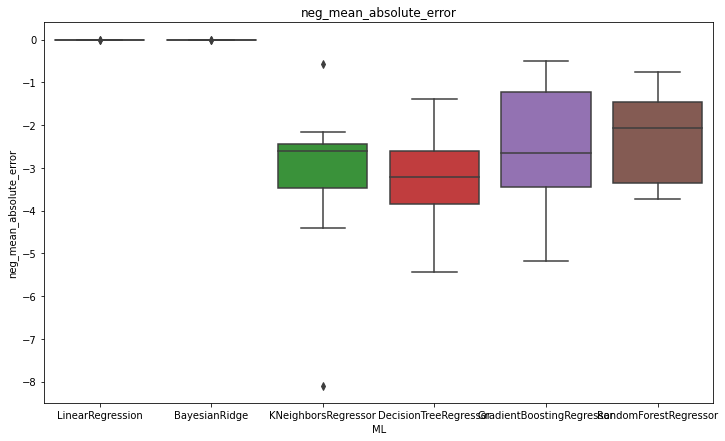

In [51]:
plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot, x = box_plot.columns[1],y=box_plot.columns[0]);

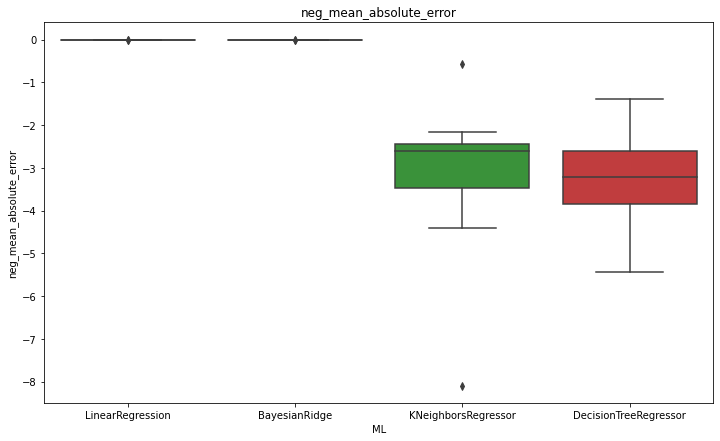

In [52]:

box_plot_new = box_plot.copy()
# box_plot_new = box_plot_new[box_plot_new['ML'] != 'Lasso']
box_plot_new = box_plot_new[box_plot_new['ML'] != 'RandomForestRegressor']
box_plot_new = box_plot_new[box_plot_new['ML'] != 'GradientBoostingRegressor']
# box_plot_new = box_plot_new[box_plot_new['ML'] != 'Lasso']
# box_plot_new = box_plot_new[box_plot_new['ML'] != 'KNeighborsRegressor']




plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot_new, x = box_plot_new.columns[1],y=box_plot_new.columns[0]);

## Fiting separate models

# DecisionTreeRegressor

In [53]:
%%time
decTree = DecisionTreeRegressor()

grid = {
    'max_features': [None, 'sqrt', 'log2', 'max_features'],
    'criterion': ['mse', 'mae'],
    'max_depth' : np.linspace(1,3, dtype=int)
}

n_splits = 3
clf1 = GridSearchCV(decTree, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=5, refit=True)

clf1.fit(X_train, y_real_train)

print()
print(clf1.best_params_)
print(clf1.best_score_)
print(clf1.best_estimator_)

name='DecisionTreeRegressor'
model = clf1
score_model = define_metrics(model, X_train, X_test, y_real_train, y_real_test, name)
score_model

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s



{'criterion': 'mse', 'max_depth': 3, 'max_features': 'log2'}
-3.852682889027752
DecisionTreeRegressor(max_depth=3, max_features='log2')
CPU times: user 923 ms, sys: 16.2 ms, total: 939 ms
Wall time: 969 ms


[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.9s finished


,name,r2,sum_squared_resid,MAPE,RMSE,durbin_watson,theil_index,ex_var
0,DecisionTreeRegressor_train,0.98467331,91.90670008,5.43217798,1.95689699,2.24260626,0.02760187,0.98467331
0,DecisionTreeRegressor_test,-6.39462339,211.72856462,12.12190704,8.40096353,0.54682912,0.07809657,-1.90668705


In [54]:
%%time
decTree_sep = clf1.best_estimator_ # DecisionTreeRegressor(criterion='mae', max_depth=4)
# decTree_sep.fit(X_train, y_real_train)

y_train_predict_decTree = decTree_sep.predict(X_train)
y_test_predict_decTree = decTree_sep.predict(X_test)

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.4 ms


### Show predictions

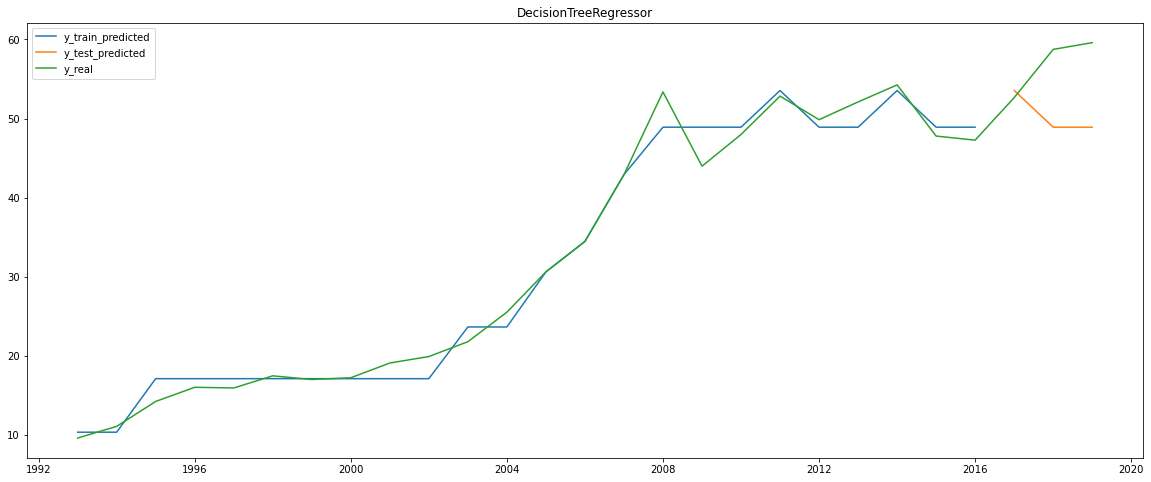

In [55]:
show_pred(y_train=y_train_predict_decTree,
         y_test=y_test_predict_decTree,
         y=y_real,
         title=name)

### Show Features importance

In [56]:
importances = decTree_sep.feature_importances_
feat_imp = dict((value, name) for value, name in zip(features, importances)) 

feat_imp = sorted(feat_imp.items(), key=lambda x: np.abs(x[1]), reverse=True)
feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'value'])



In [57]:
feat_imp

,feature,value
0,window_mean_2,0.89456975
1,y-2,0.04748428
2,window_mean_3,0.04624942
3,window_std_3,0.00603296
4,y-3,0.00566359
5,y-1,0.00000000
6,window_std_2,0.00000000


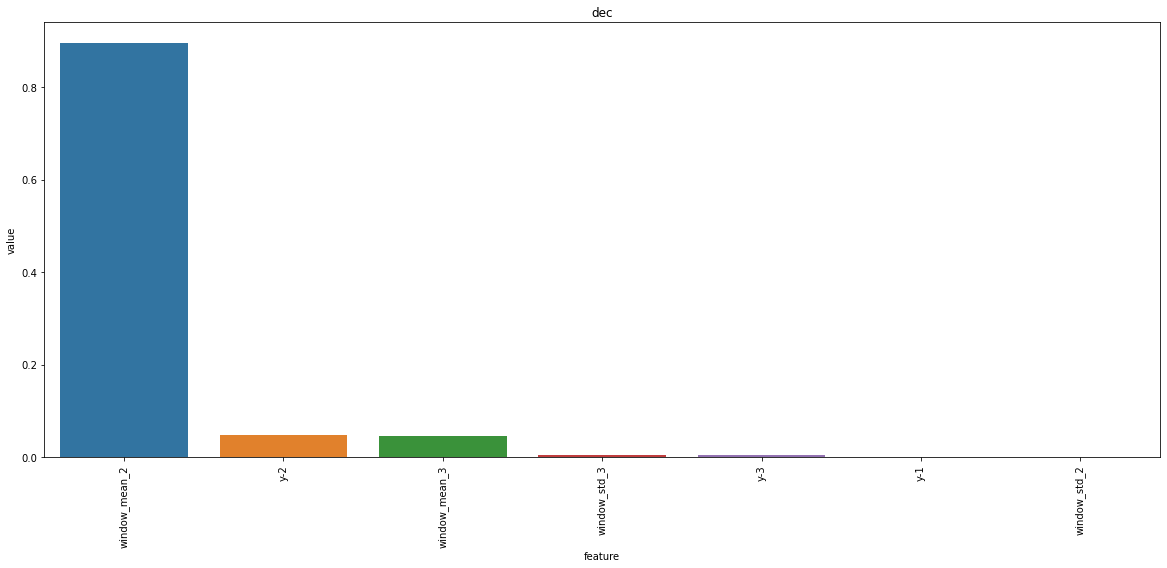

In [58]:
barplot(feat_imp, title='dec')

# LinearRegression

In [59]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_real_train)

y_train_predict_linReg = lin_reg.predict(X_train)
y_test_predict_linReg = lin_reg.predict(X_test)
name = 'LinearRegression'

CPU times: user 4.32 ms, sys: 12 µs, total: 4.34 ms
Wall time: 3.98 ms


### Show predictions

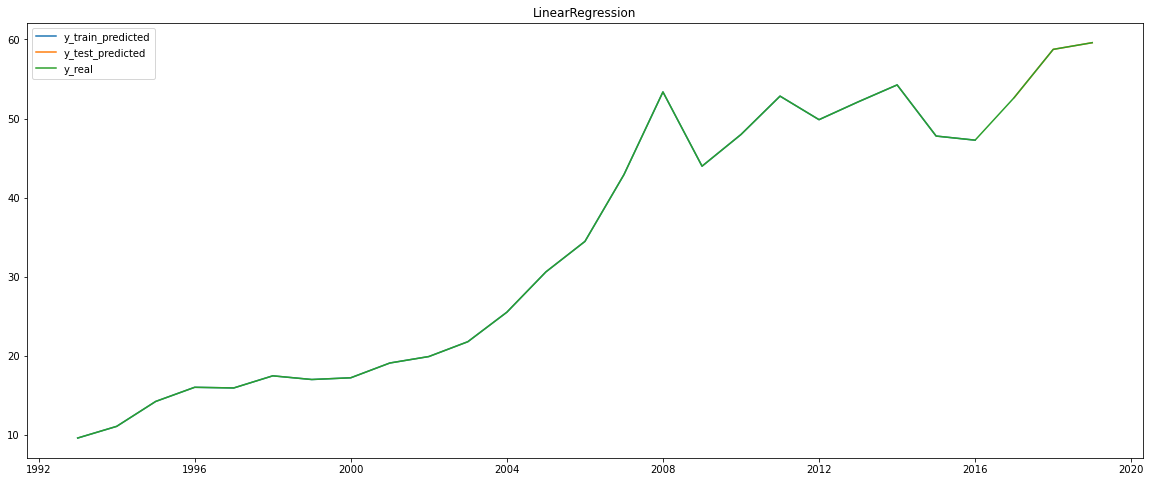

In [60]:
show_pred(y_train=y_train_predict_linReg,
         y_test=y_test_predict_linReg,
         y=y_real,
         title=name)

### Show Features importance

In [61]:
importances = lin_reg.coef_
feat_imp = dict((value, name) for value, name in zip(features, importances)) 

feat_imp = sorted(feat_imp.items(), key=lambda x: np.abs(x[1]), reverse=True)
feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'value'])



In [62]:
feat_imp

,feature,value
0,window_mean_2,1.42857143
1,y-1,-1.00000000
2,window_mean_3,0.85714286
3,y-2,-0.28571429
4,window_std_3,-0.00000000
5,y-3,-0.00000000
6,window_std_2,0.00000000


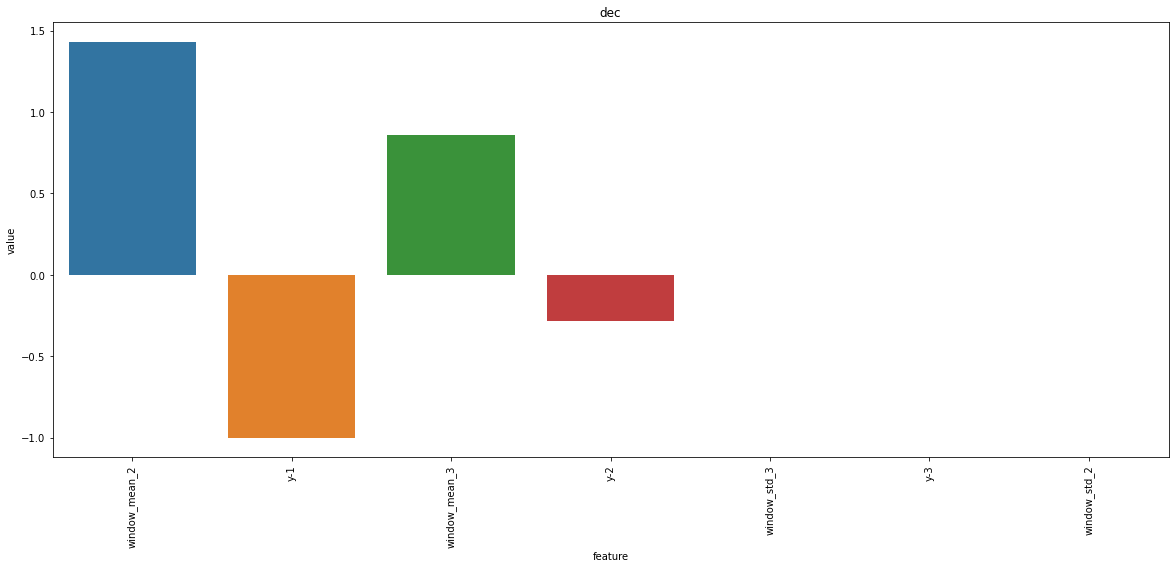

In [63]:
barplot(feat_imp, title='dec')

# KNeighborsRegressor

In [71]:
%%time
knn = KNeighborsRegressor()
grid = {'n_neighbors': np.linspace(2,5, dtype=int),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']
}

n_splits = 3
clf2 = GridSearchCV(knn, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=5, refit=True)

clf2.fit(X_train, y_real_train)

print()
print(clf2.best_params_)
print(clf2.best_score_)
print(clf2.best_estimator_)

name='KNeighborsRegressor'
model = clf2
score_model = define_metrics(model, X_train, X_test, y_real_train, y_real_test, name)
score_model

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s



{'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'distance'}
-1.6560163393941014
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=2, weights='distance')
CPU times: user 887 ms, sys: 20.2 ms, total: 907 ms
Wall time: 1.01 s


[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    1.0s finished


,name,r2,sum_squared_resid,MAPE,RMSE,durbin_watson,theil_index,ex_var
0,KNeighborsRegressor_train,1.00000000,0.00000000,0.00000000,0.00000000,nan,0.00000000,1.00000000
0,KNeighborsRegressor_test,-3.17807557,119.62988476,9.07353818,6.31479440,0.49090345,0.05782379,-0.69269037


In [72]:
%%time
knn_sep = clf2.best_estimator_ # DecisionTreeRegressor(criterion='mae', max_depth=4)
# decTree_sep.fit(X_train, y_real_train)

y_train_predict_knn= knn_sep.predict(X_train)
y_test_predict_knn = knn_sep.predict(X_test)

CPU times: user 5.37 ms, sys: 55 µs, total: 5.43 ms
Wall time: 4.89 ms


### Show predictions

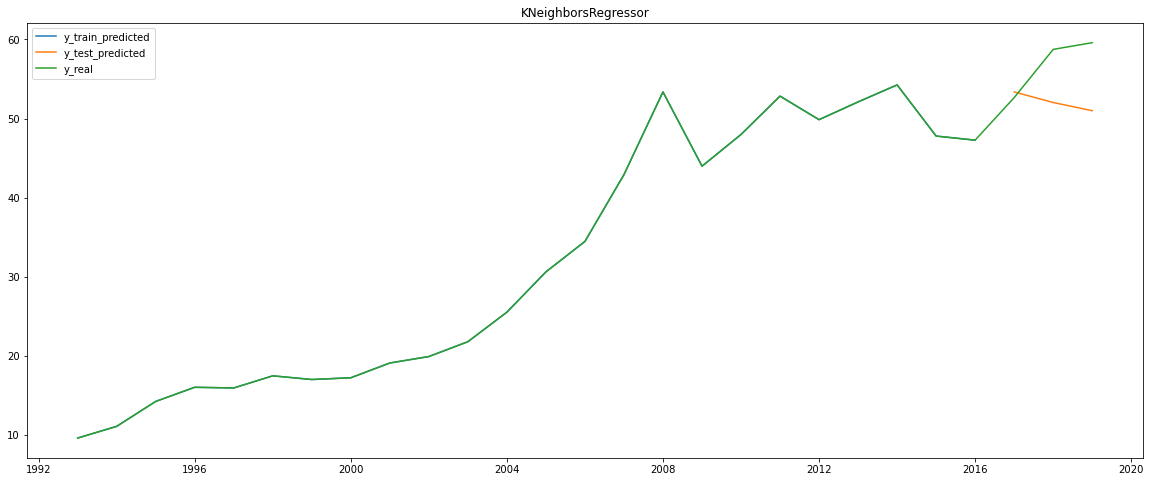

In [73]:
show_pred(y_train=y_train_predict_knn,
         y_test=y_test_predict_knn,
         y=y_real,
         title=name)

# BayesianRidge

In [74]:
%%time
bayes = BayesianRidge()
grid = {'n_iter': np.linspace(100,500, 5,dtype=int)
}

n_splits = 10
clf3 = GridSearchCV(bayes, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=5, refit=True)

clf3.fit(X_train, y_real_train)

print()
print(clf3.best_params_)
print(clf3.best_score_)
print(clf3.best_estimator_)

name='BayesianRidge'
model = clf3
score_model = define_metrics(model, X_train, X_test, y_real_train, y_real_test, name)
score_model

Fitting 10 folds for each of 5 candidates, totalling 50 fits

{'n_iter': 100}
-2.5063991835475956e-05
BayesianRidge(n_iter=100)
CPU times: user 109 ms, sys: 3.97 ms, total: 113 ms
Wall time: 113 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  50 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


,name,r2,sum_squared_resid,MAPE,RMSE,durbin_watson,theil_index,ex_var
0,BayesianRidge_train,1.00000000,0.00000000,0.00000639,0.00000278,1.32664848,0.00000004,1.00000000
0,BayesianRidge_test,1.00000000,0.00000000,0.00000392,0.00000287,0.71595828,0.00000003,1.00000000


In [75]:
%%time
bayes_sep = clf3.best_estimator_ # DecisionTreeRegressor(criterion='mae', max_depth=4)
# decTree_sep.fit(X_train, y_real_train)

y_train_predict_bayes = bayes_sep.predict(X_train)
y_test_predict_bayes = bayes_sep.predict(X_test)

CPU times: user 2.16 ms, sys: 0 ns, total: 2.16 ms
Wall time: 2.16 ms


### Show predictions

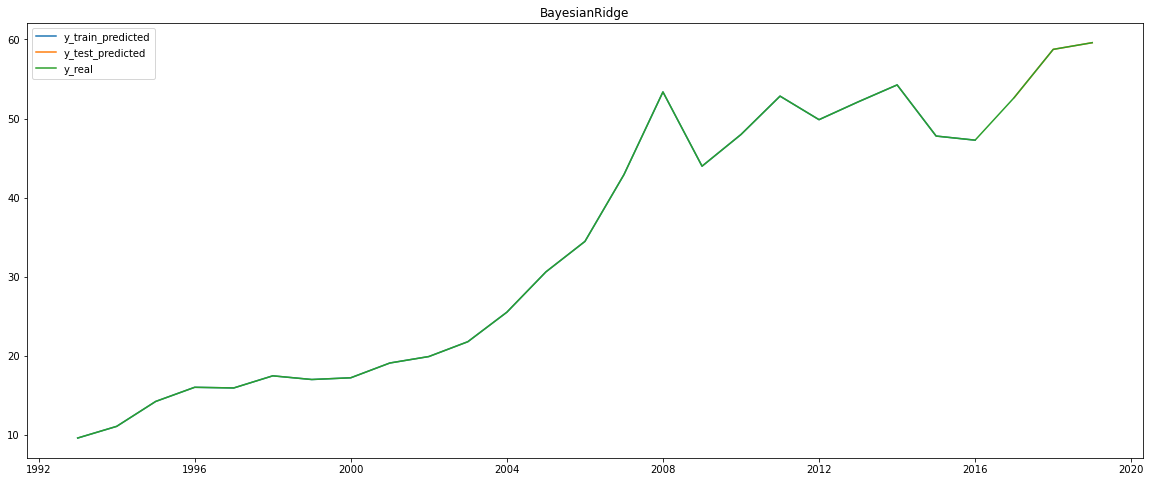

In [76]:
show_pred(y_train=y_train_predict_bayes,
         y_test=y_test_predict_bayes,
         y=y_real,
         title=name)

### Show Features importance

In [77]:
importances = bayes_sep.coef_
feat_imp = dict((value, name) for value, name in zip(features, importances)) 

feat_imp = sorted(feat_imp.items(), key=lambda x: np.abs(x[1]), reverse=True)
feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'value'])



In [78]:
feat_imp

,feature,value
0,window_mean_2,1.42856789
1,y-1,-0.99999999
2,window_mean_3,0.85714912
3,y-2,-0.28571701
4,window_std_3,0.00000001
5,window_std_2,-0.00000000
6,y-3,0.00000000


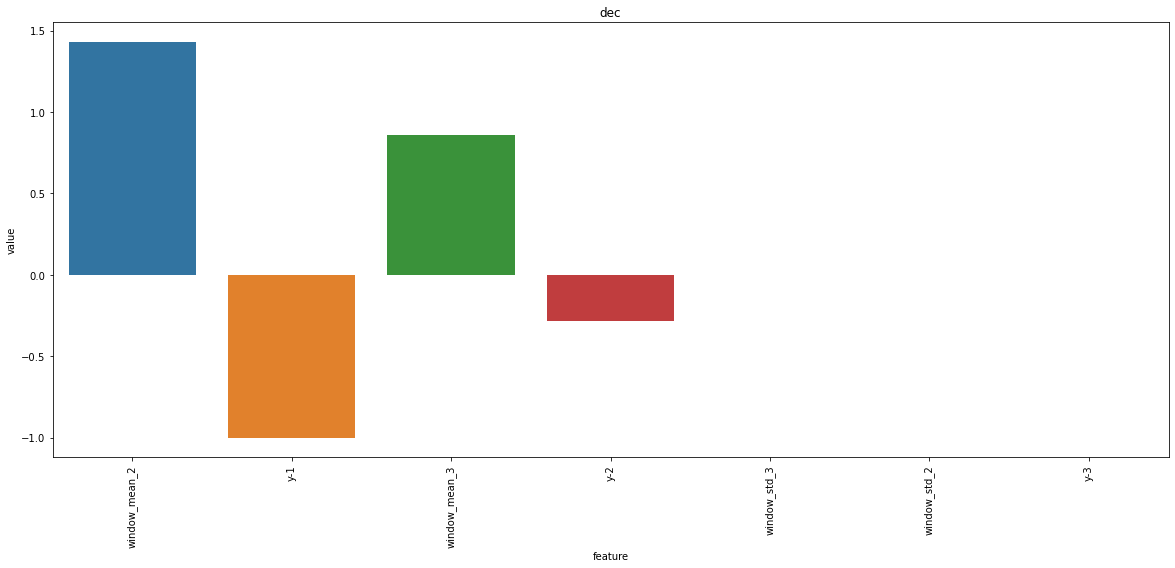

In [79]:
barplot(feat_imp, title='dec')